# 03_temp_ndvi (strongest correlation) in different cities

This notebook explores the __strongest correlation found__ (for temperature data in Guadalajara, __notebook 01-temp_data_exploration__, which was corr. with __NDVI__) in __different cities.__

## Import libraries

In [1]:
from pathlib import Path

current_path = Path().resolve()

for parent in current_path.parents:
    if parent.name == "accesibilidad-urbana":
        project_root = parent
        break

print(project_root)

/home/jovyan/accesibilidad-urbana


In [2]:
import os
import sys

import pandas as pd
import geopandas as gpd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns

# Correlation calc
import scipy.stats as stats

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join(project_root))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup
else:
    import aup

## Notebook config

In [3]:
#Falta mucha info:
#Puebla no tiene temperatura
#León no tiene NDVI
#SLP no tiene NDVI
#Mérida no tiene NDVI
#Mexicali no tiene temperatura
#Saltillo no tiene NDVI

city_lst = ['ZMVM']
#city_lst = ['CDMX','Monterrey','Guadalajara','Toluca','Tijuana','Queretaro','Juarez','Laguna','Aguascalientes','Cuernavaca'] 
#city_lst = ['Aguascalientes'] #Pruebas

projected_crs = "EPSG:6372"
res = 11
# Filter for urban areas only
filter_urban = True
# Save resulting plots?
save_plots = False
plots_output_dir = str(project_root)+f"/output/figures/temperature/2025_check/"
# Save resulting tables for GIS analysis?
save_output = True
temp_output_dir = str(project_root)+f"/data/external/temporal_fromjupyter/temp_check/"
ndvi_output_dir = str(project_root)+f"/data/external/temporal_fromjupyter/temp_check/"

## Plots config

In [4]:
# Format - Style
sns.set_style("white")

## Load data

In [5]:
# Slope function
def calc_slope(row, cols):
    data = row[cols].astype(float).values
    slope, intercept = np.polyfit(years, data, 1)
    return slope

Loading ZMVM's urban hexs.
Loading ZMVM's temperature data.
Loading ZMVM's NDVI data.
Calculating ZMVM's temperature anomaly.
Mean temperature in ZMVM: 34.81734537451422.
Calculating ZMVM's temperature and NDVI slopes.
Merging ZMVM's temperature and NDVI data.
--- ZMVM - 614513 Temperature hexs.
--- ZMVM - 614513 NDVI hexs.
--- ZMVM - 614513 Temperature + NDVI hexs
Plotting ZMVM's data.


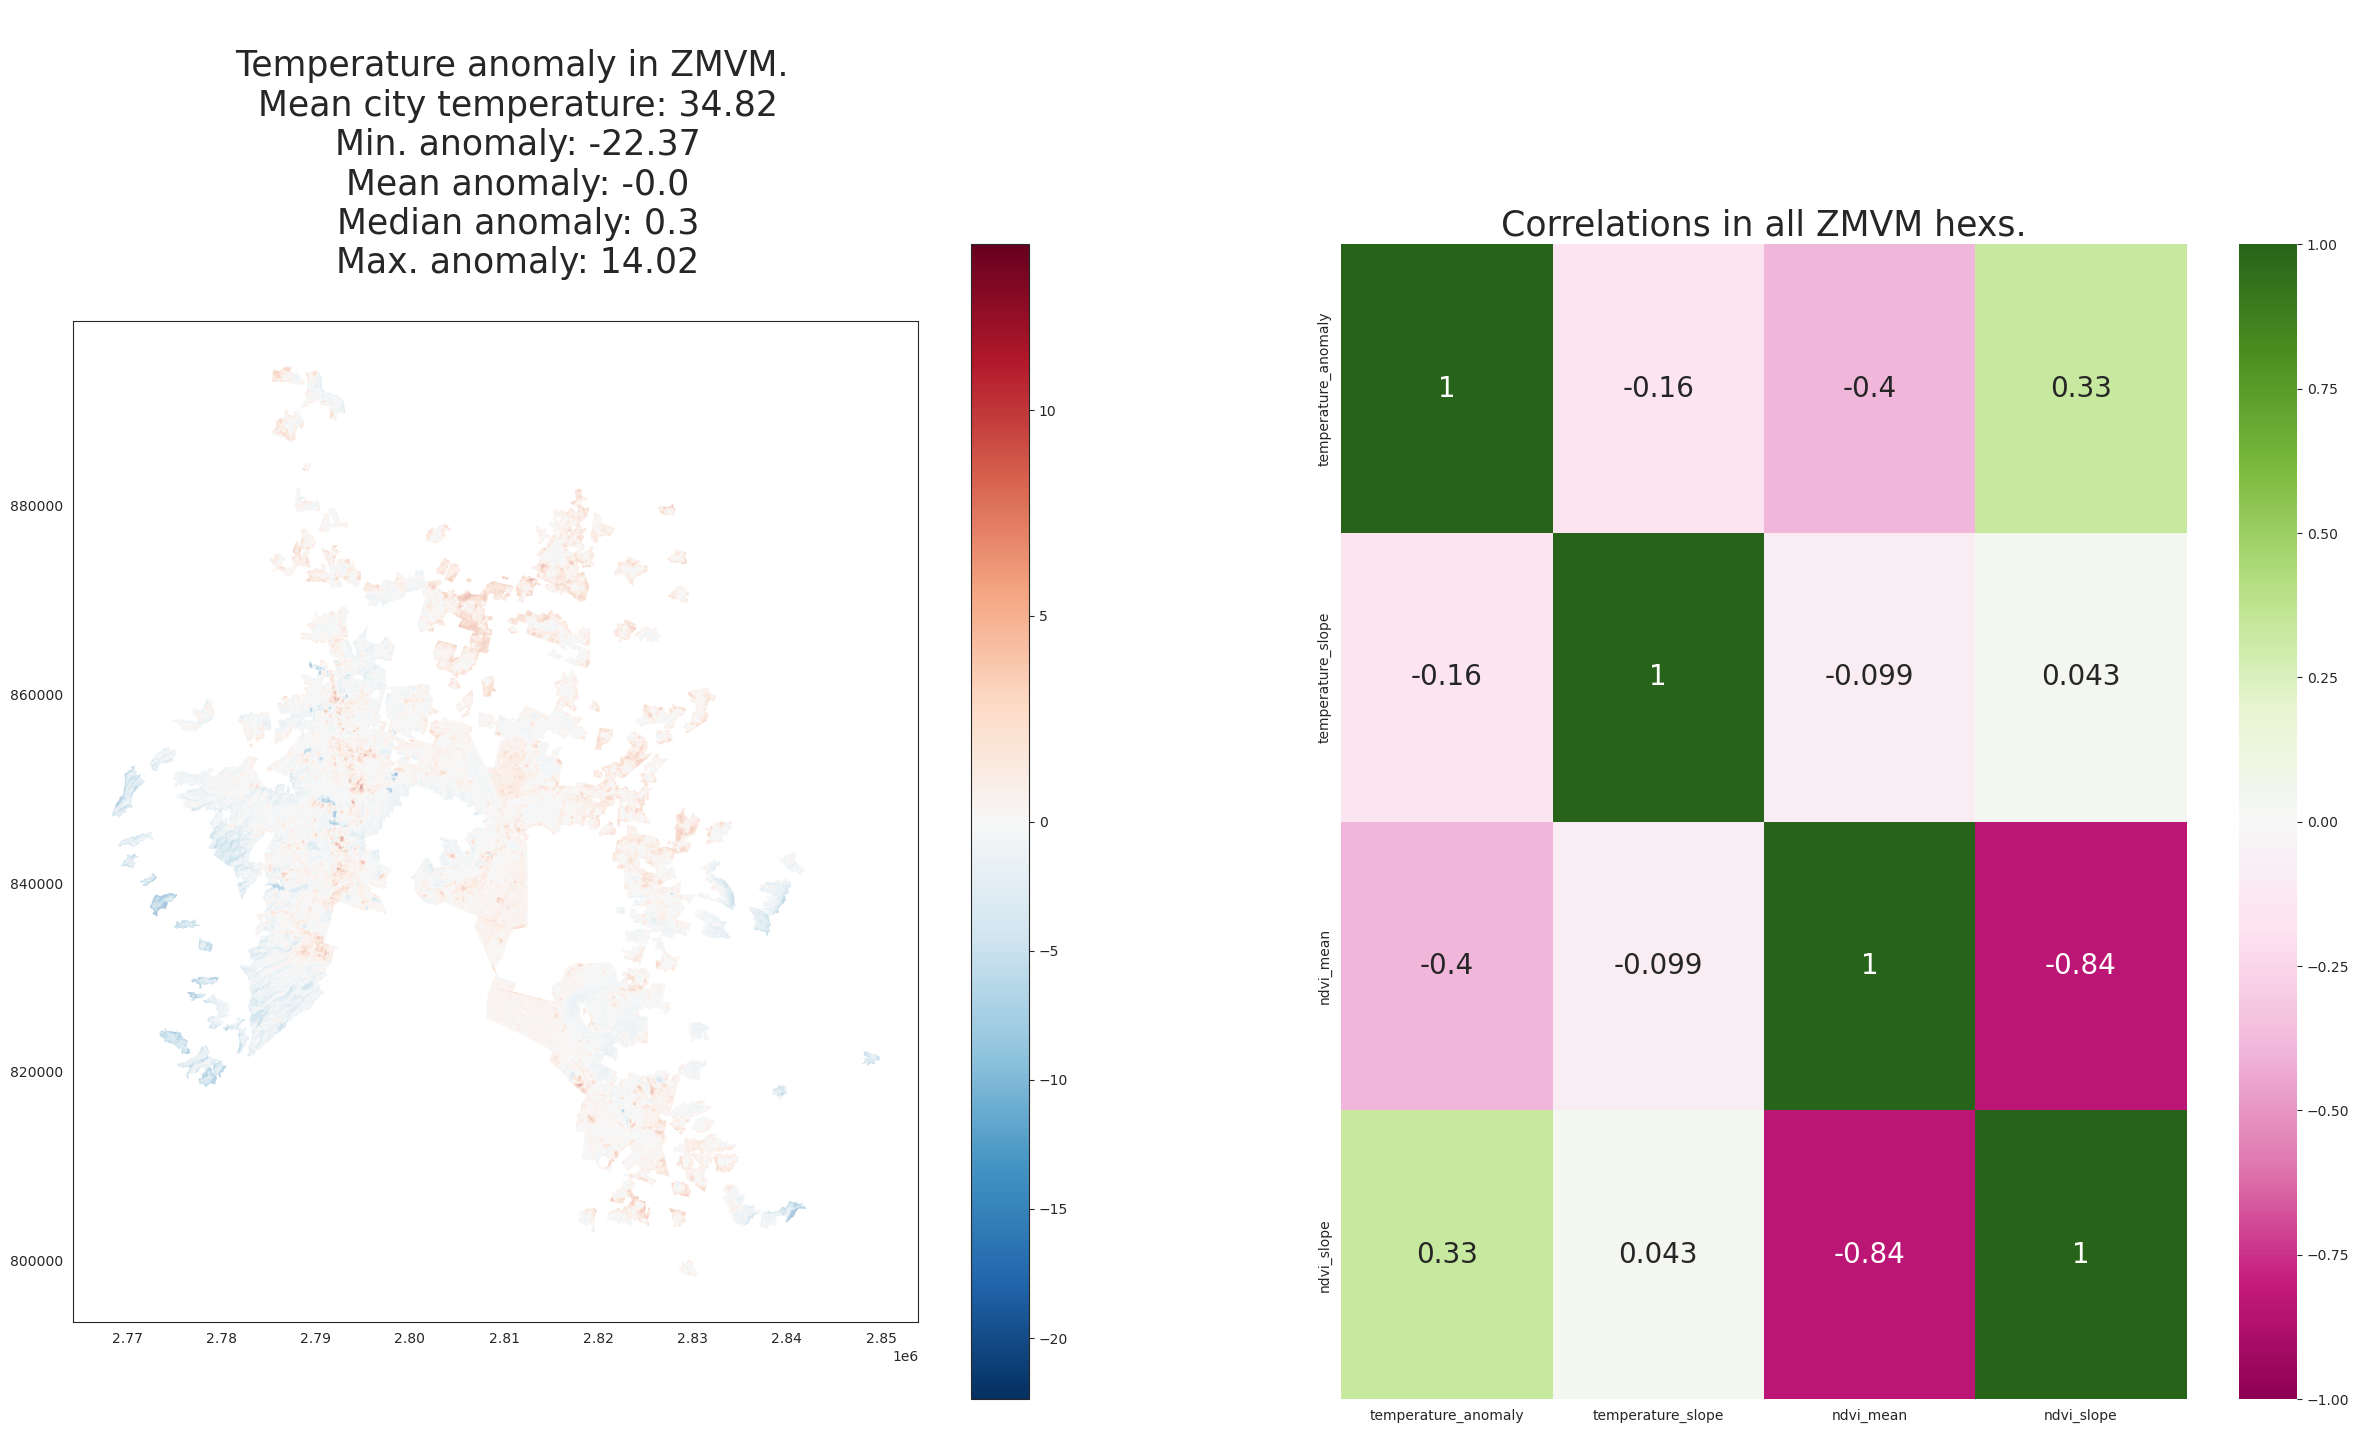

In [6]:
for city in city_lst:

    # 1.0 --- --- --- LOAD DATA --- --- ---
    
    # 1.1 --- LOAD URBAN HEXS
    print(f"Loading {city}'s urban hexs.")
    # Load data
    hex_schema = 'hexgrid'
    hex_table = f'hexgrid_{res}_city_2020'
    # Filter for urban areas if required
    if filter_urban:
        hex_type = 'urban'
        query = f"SELECT hex_id_{res}, geometry FROM {hex_schema}.{hex_table} WHERE \"city\" = '{city}\' AND \"type\" = '{hex_type}\'"
    else:
        query = f"SELECT hex_id_{res}, geometry FROM {hex_schema}.{hex_table} WHERE \"city\" = '{city}\'"
    # Read and format cols
    hex_gdf = aup.gdf_from_query(query, geometry_col='geometry')
    hex_gdf['res'] = res
    hex_gdf.rename(columns={f'hex_id_{res}':'hex_id'},inplace=True)
    hex_gdf.to_crs(projected_crs,inplace=True)
    # List all unique hex_ids
    hexid_lst = list(hex_gdf.hex_id.unique())

    # 1.2 --- LOAD TEMPERATURE DATA
    print(f"Loading {city}'s temperature data.")
    # Load data
    temp_schema = 'raster_analysis'
    temp_table = 'temperature_analysis_hex'
    query = f"SELECT * FROM {temp_schema}.{temp_table} WHERE \"city\" = '{city}\' AND \"res\" = '{res}\'"
    temperature_gdf = aup.gdf_from_query(query, geometry_col='geometry')
    temperature_gdf.to_crs(projected_crs,inplace=True)
    # Filter for urban areas if required
    if filter_urban:
        temperature_gdf = temperature_gdf.loc[temperature_gdf.hex_id.isin(hexid_lst)].copy()
    # Inf values check
    infs = temperature_gdf.loc[np.isinf(temperature_gdf['temperature_mean'])]
    if len(infs)>0:
        print(f"WARNING: Dropping {len(infs)} hexs res {res} because of inf values.")
        temperature_gdf = temperature_gdf.loc[~np.isinf(temperature_gdf['temperature_mean'])].copy()

    # 1.3 --- LOAD NDVI DATA
    print(f"Loading {city}'s NDVI data.")
    ndvi_schema = 'raster_analysis'
    ndvi_table = 'ndvi_analysis_hex'
    query = f"SELECT * FROM {ndvi_schema}.{ndvi_table} WHERE \"city\" = '{city}\' AND \"res\" = '{res}\'"
    ndvi_gdf = aup.gdf_from_query(query, geometry_col='geometry')
    ndvi_gdf.to_crs(projected_crs,inplace=True)
    # Filter for urban areas if required
    if filter_urban:
        ndvi_gdf = ndvi_gdf.loc[ndvi_gdf.hex_id.isin(hexid_lst)].copy()
    # Inf values check
    infs = ndvi_gdf.loc[np.isinf(ndvi_gdf['ndvi_mean'])]
    if len(infs)>0:
        print(f"WARNING: Dropping {len(infs)} hexs res {res} because of inf values.")
        ndvi_gdf = ndvi_gdf.loc[~np.isinf(ndvi_gdf['ndvi_mean'])].copy()

    # 2.0 --- --- --- CALCULATIONS --- --- ---

    # 2.1 --- CALCULATE TEMPERATURE ANOMALY
    print(f"Calculating {city}'s temperature anomaly.")
    # Calculate anomaly (differential between mean in each hex and city mean)
    mean_city_temperature = temperature_gdf.temperature_mean.mean()
    print(f"Mean temperature in {city}: {mean_city_temperature}.")
    temperature_gdf['temperature_anomaly'] = temperature_gdf['temperature_mean'] - mean_city_temperature

    # 2.2 --- CALCULATE TEMPERATURE AND NDVI SLOPES
    print(f"Calculating {city}'s temperature and NDVI slopes.")
    years = np.array([2018, 2019, 2020, 2021, 2022, 2023])
    # --- --- --- Calculate slopes
    # Temperature
    temp_columns = [f'temperature_{year}' for year in years]
    temperature_gdf['temperature_slope'] = temperature_gdf.apply(calc_slope, args=(temp_columns,), axis=1)
    # NDVI
    ndvi_columns = [f'ndvi_{year}' for year in years]
    ndvi_gdf['ndvi_slope'] = ndvi_gdf.apply(calc_slope, args=(ndvi_columns,), axis=1)

    # 3.0 --- --- --- SAVE (IF REQUESTED) AND MERGE DATA --- --- ---
    
    # 3.1 --- SAVE TEMPERATURE AND NDVI ANOMALY AND SLOPE DATA FOR GIS MAPS
    if save_output:
        temperature_gdf.to_file(temp_output_dir + f"temperature_res{res}_{city}.gpkg")
        ndvi_gdf.to_file(ndvi_output_dir + f"ndvi_res{res}_{city}.gpkg")
    
    # 3.2 --- MERGE TEMPERATURE AND NDVI DATA
    print(f"Merging {city}'s temperature and NDVI data.")
    print(f"--- {city} - {len(temperature_gdf)} Temperature hexs.")
    print(f"--- {city} - {len(ndvi_gdf)} NDVI hexs.")
    exploration_gdf = pd.merge(temperature_gdf[['hex_id','temperature_anomaly','temperature_slope','geometry']],
                                 ndvi_gdf[['hex_id','ndvi_mean','ndvi_slope']],on='hex_id')
    print(f"--- {city} - {len(exploration_gdf)} Temperature + NDVI hexs")
    
    # 4.0 --- --- --- PLOTS --- --- ---
    fig,axs = plt.subplots(1,2,figsize=(30,15))
    
    # 4.1 --- TEMPERATURE ANOMALY PLOT
    print(f"Plotting {city}'s data.")
    # Calculate main data of interest
    min_anomaly = round(exploration_gdf.temperature_anomaly.min(),2)
    mean_anomaly = round(exploration_gdf.temperature_anomaly.mean(),2)
    median_anomaly = round(exploration_gdf.temperature_anomaly.median(),2)
    max_anomaly = round(exploration_gdf.temperature_anomaly.max(),2)
    
    # Prepare plot
    # Set color ranges (Specially 0 = white)
    divnorm=colors.TwoSlopeNorm(vmin = exploration_gdf.temperature_anomaly.min(), 
                                vcenter = 0, 
                                vmax = exploration_gdf.temperature_anomaly.max()
                               )
    # Plot
    sns.set_style("white")
    exploration_gdf.plot('temperature_anomaly',
                         legend=True, 
                         cmap='RdBu_r',
                         norm=divnorm,
                         linewidth=0.1,
                         ax=axs[0])

    # Format - Make sure axs[0] has white, no gridlines background, and that there is a frame (spine) [.grid(False) deletes the frame]
    axs[0].set_facecolor("white")
    axs[0].grid(False)
    for spine in axs[0].spines.values():
        spine.set_visible(True)

    # Format - Title
    axs[0].set_title(f"""
    Temperature anomaly in {city}. 
    Mean city temperature: {round(mean_city_temperature,2)}
    Min. anomaly: {min_anomaly}
    Mean anomaly: {mean_anomaly}
    Median anomaly: {median_anomaly}
    Max. anomaly: {max_anomaly}
    """,
    fontdict = {'fontsize':25}
    )
    
    # 4.2 --- CORRELATION PLOT
    summary_cols = ['temperature_anomaly','temperature_slope','ndvi_mean','ndvi_slope']
    # Isolate data of interest
    data_gdf = exploration_gdf[summary_cols].copy()
    # Create correlation heatmap
    sns.heatmap(data_gdf.corr(), 
                annot =True,
                vmin=-1, vmax=1, center=0, # Similar to 'norm' in .plot(). Sets the same correlations colorpalette ranges for all cities.
                cmap="PiYG",
                annot_kws={"fontsize":20}, 
                ax=axs[1])
    # Seaborn plot format
    sns.set(rc = {'figure.figsize':(5,5)})
    # Show
    axs[1].set_title(f"Correlations in all {city} hexs.",
                    fontdict = {'fontsize':25}
                    )
    # 4.3 --- SAVE PLOT
    if save_plots:
        plt.savefig(plots_output_dir + f"{city}_tempanomaly_correlations.png")